# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="cifar10.jpg" style="width:80%">

In [3]:
# when running in colab, un-comment this
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

--2024-11-11 11:49:10--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2396 (2.3K) [text/plain]
Saving to: ‘cifar.py’

cifar.py            100%[===================>]   2.34K  --.-KB/s    in 0s      

2024-11-11 11:49:10 (39.8 MB/s) - ‘cifar.py’ saved [2396/2396]



In [4]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

Dataset not found. Downloading...
(40000, 3, 32, 32) (40000,)


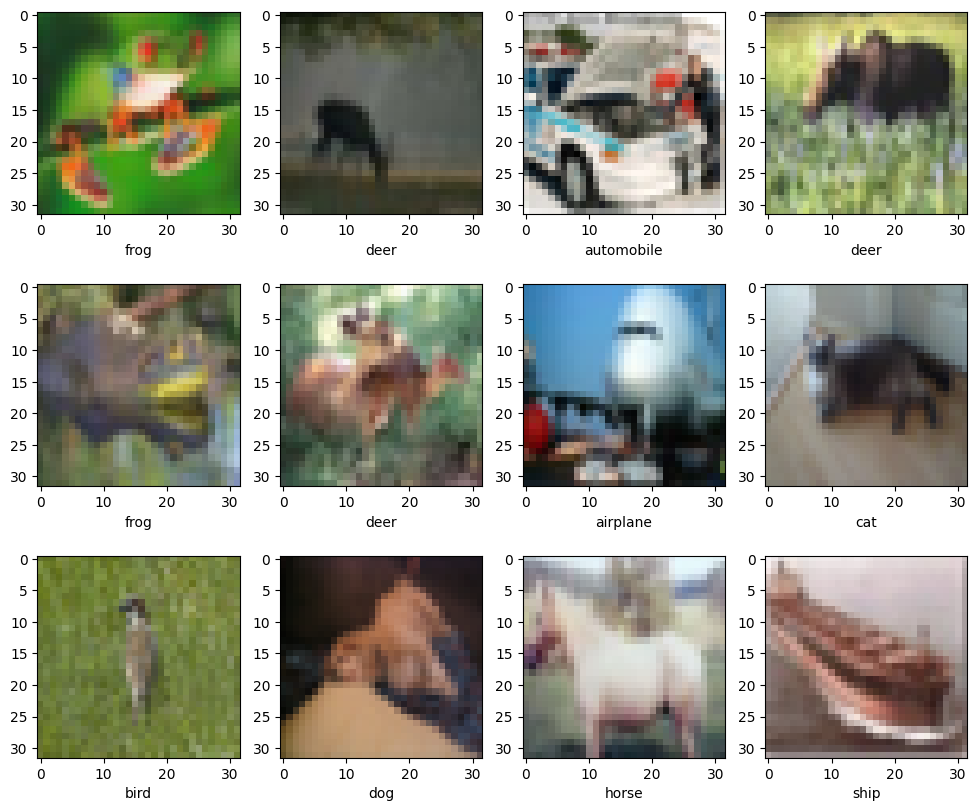

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [6]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [7]:
if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)
device

device(type='cpu')

Let's start with a dense network for our baseline:

In [6]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 64))
model.add_module('dense1_relu', nn.ReLU())
model.add_module('dense2_logits', nn.Linear(64, 10)) # logits for 10 classes
model.to(device)

Sequential(
  (flatten): Flatten()
  (dense1): Linear(in_features=3072, out_features=64, bias=True)
  (dense1_relu): ReLU()
  (dense2_logits): Linear(in_features=64, out_features=10, bias=True)
)

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [16]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32).to(device)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64).to(device)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [8]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2313, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [14]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [10]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [11]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        y_pred = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 100 took 2.568s
  training loss (in-iteration): 	2.041690
  validation accuracy: 			33.31 %
Epoch 2 of 100 took 2.451s
  training loss (in-iteration): 	1.861351
  validation accuracy: 			36.94 %
Epoch 3 of 100 took 2.115s
  training loss (in-iteration): 	1.792621
  validation accuracy: 			38.15 %
Epoch 4 of 100 took 3.244s
  training loss (in-iteration): 	1.741950
  validation accuracy: 			39.65 %
Epoch 5 of 100 took 2.055s
  training loss (in-iteration): 	1.700233
  validation accuracy: 			40.52 %
Epoch 6 of 100 took 2.024s
  training loss (in-iteration): 	1.662624
  validation accuracy: 			41.25 %
Epoch 7 of 100 took 1.599s
  training loss (in-iteration): 	1.633869
  validation accuracy: 			43.39 %
Epoch 8 of 100 took 1.579s
  training loss (in-iteration): 	1.608751
  validation accuracy: 			43.27 %
Epoch 9 of 100 took 1.583s
  training loss (in-iteration): 	1.587578
  validation accuracy: 			43.46 %
Epoch 10 of 100 took 1.782s
  training loss (in-iteration): 	1.570392
  v

Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.

### Final test

In [12]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    y_pred = logits.max(1)[1].cpu().data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		49.60 %
We need more magic! Follow instructons below


## Task I: small convolution net
### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and _ReLU_ activation
* 2x2 pooling (or set previous convolution stride to 3)
* Flatten
* Dense layer with 100 neurons and _ReLU_ activation
* 10% dropout
* Output dense layer.


__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with default params (feel free to modify the code above).

If everything is right, you should get at least __50%__ validation accuracy.

In [13]:
model = nn.Sequential()

# Convolutional layers with activations and pooling
model.add_module('conv1', nn.Conv2d(3, 16, kernel_size=3))
model.add_module('relu1', nn.ReLU())
model.add_module('conv2', nn.Conv2d(16, 32, kernel_size=3))
model.add_module('pool', nn.MaxPool2d(kernel_size=2))
model.add_module('conv3', nn.Conv2d(32, 64, kernel_size=3))

# Flatten and add dense layers
model.add_module('flatten', Flatten())
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('dense1', nn.Linear(64 * 12 * 12, 64))
model.add_module('relu2', nn.ReLU())
model.add_module('output', nn.Linear(64, 10))

model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train_losses, validation_accuracies = [], []

# Training loop
for epoch in range(100):
    start_time = time.time()
    model.train(True)
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, 50):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.cpu().data.numpy())

    # Validation
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, 50):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        predictions = logits.max(1)[1].cpu().data.numpy()
        validation_accuracies.append(np.mean(y_batch == predictions))

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, 100, time.time() - start_time))
    print("  training loss: {:.6f}".format(np.mean(train_losses[-len(X_train) // 50 :])))
    print("  validation accuracy: {:.2f} %".format(np.mean(validation_accuracies[-len(X_val) // 50 :]) * 100))

# Final evaluation
model.train(False)
test_accuracies = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    predictions = logits.max(1)[1].cpu().data.numpy()
    test_accuracies.append(np.mean(y_batch == predictions))

final_test_accuracy = np.mean(test_accuracies)
print("Final results:")
print("  test accuracy: {:.2f} %".format(final_test_accuracy * 100))

if final_test_accuracy * 100 > 95:
    print("Double-check, then consider applying for NIPS'17. Seriously.")
elif final_test_accuracy * 100 > 90:
    print("You're amazing!")
elif final_test_accuracy * 100 > 80:
    print("Achievement unlocked: 110-level Warlock!")
elif final_test_accuracy * 100 > 70:
    print("Achievement unlocked: 80-level Warlock!")
elif final_test_accuracy * 100 > 60:
    print("Achievement unlocked: 70-level Warlock!")
elif final_test_accuracy * 100 > 50:
    print("Achievement unlocked: 60-level Warlock!")
else:
    print("We need more practice! Follow the instructions below.")

Epoch 1 of 100 took 65.032s
  training loss: 2.116635
  validation accuracy: 31.03 %
Epoch 2 of 100 took 64.261s
  training loss: 1.834264
  validation accuracy: 37.31 %
Epoch 3 of 100 took 62.761s
  training loss: 1.666365
  validation accuracy: 44.29 %
Epoch 4 of 100 took 65.853s
  training loss: 1.542733
  validation accuracy: 47.17 %
Epoch 5 of 100 took 64.124s
  training loss: 1.463671
  validation accuracy: 49.99 %
Epoch 6 of 100 took 63.561s
  training loss: 1.402752
  validation accuracy: 51.78 %
Epoch 7 of 100 took 63.053s
  training loss: 1.348384
  validation accuracy: 51.98 %
Epoch 8 of 100 took 63.915s
  training loss: 1.295118
  validation accuracy: 54.75 %
Epoch 9 of 100 took 64.655s
  training loss: 1.247642
  validation accuracy: 55.66 %
Epoch 10 of 100 took 63.018s
  training loss: 1.198120
  validation accuracy: 56.70 %
Epoch 11 of 100 took 63.847s
  training loss: 1.148375
  validation accuracy: 57.28 %
Epoch 12 of 100 took 62.518s
  training loss: 1.104402
  valida

__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

## Task 2: adding normalization

* Add batch norm (with default params) between convolution and ReLU
  * nn.BatchNorm*d (1d for dense, 2d for conv)
  * usually better to put them after linear/conv but before nonlinearity
* Re-train the network with the same optimizer, it should get at least 60% validation accuracy at peak.



In [14]:
# Define the model with batch normalization layers
model = nn.Sequential()

# Convolutional layers with batch normalization and ReLU
model.add_module('conv_layer1', nn.Conv2d(3, 16, kernel_size=3))
model.add_module('batch_norm1', nn.BatchNorm2d(16))
model.add_module('relu1', nn.ReLU())
model.add_module('conv_layer2', nn.Conv2d(16, 32, kernel_size=3))
model.add_module('batch_norm2', nn.BatchNorm2d(32))
model.add_module('max_pool', nn.MaxPool2d(kernel_size=2))
model.add_module('conv_layer3', nn.Conv2d(32, 64, kernel_size=3))

# Flatten and fully connected layers with dropout
model.add_module('flatten', Flatten())
model.add_module('dropout', nn.Dropout(p=0.1))
model.add_module('dense_layer1', nn.Linear(64 * 12 * 12, 64))
model.add_module('relu2', nn.ReLU())
model.add_module('output_logits', nn.Linear(64, 10))

model.to(device)

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train_losses, validation_accuracies = [], []

# Training loop
for epoch in range(100):
    start_time = time.time()
    model.train(True)
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, 50):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(loss.cpu().data.numpy())

    # Validation phase
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, 50):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        predictions = logits.max(1)[1].cpu().data.numpy()
        validation_accuracies.append(np.mean(y_batch == predictions))

    print("Epoch {} of {} took {:.3f}s".format(epoch + 1, 100, time.time() - start_time))
    print("  training loss: {:.6f}".format(np.mean(train_losses[-len(X_train) // 50 :])))
    print("  validation accuracy: {:.2f} %".format(np.mean(validation_accuracies[-len(X_val) // 50 :]) * 100))

# Test evaluation
model.train(False)
test_accuracies = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    predictions = logits.max(1)[1].cpu().data.numpy()
    test_accuracies.append(np.mean(y_batch == predictions))

final_test_accuracy = np.mean(test_accuracies)
print("Final results:")
print("  test accuracy: {:.2f} %".format(final_test_accuracy * 100))

# Print achievement message based on accuracy
if final_test_accuracy * 100 > 95:
    print("Double-check, then consider applying for NIPS'17. Seriously.")
elif final_test_accuracy * 100 > 90:
    print("You're amazing!")
elif final_test_accuracy * 100 > 80:
    print("Achievement unlocked: 110-level Warlock!")
elif final_test_accuracy * 100 > 70:
    print("Achievement unlocked: 80-level Warlock!")
elif final_test_accuracy * 100 > 60:
    print("Achievement unlocked: 70-level Warlock!")
elif final_test_accuracy * 100 > 50:
    print("Achievement unlocked: 60-level Warlock!")
else:
    print("We need more practice! Follow the instructions below.")

Epoch 1 of 100 took 73.884s
  training loss: 1.492512
  validation accuracy: 56.21 %
Epoch 2 of 100 took 74.969s
  training loss: 1.158392
  validation accuracy: 44.83 %
Epoch 3 of 100 took 74.159s
  training loss: 1.010221
  validation accuracy: 60.52 %
Epoch 4 of 100 took 75.444s
  training loss: 0.904605
  validation accuracy: 63.03 %
Epoch 5 of 100 took 73.570s
  training loss: 0.826160
  validation accuracy: 66.12 %
Epoch 6 of 100 took 73.232s
  training loss: 0.761088
  validation accuracy: 57.14 %
Epoch 7 of 100 took 74.158s
  training loss: 0.696400
  validation accuracy: 62.11 %
Epoch 8 of 100 took 72.597s
  training loss: 0.636951
  validation accuracy: 58.07 %
Epoch 9 of 100 took 73.798s
  training loss: 0.581959
  validation accuracy: 64.97 %
Epoch 10 of 100 took 72.452s
  training loss: 0.528200
  validation accuracy: 66.84 %
Epoch 11 of 100 took 73.892s
  training loss: 0.475412
  validation accuracy: 66.89 %
Epoch 12 of 100 took 72.995s
  training loss: 0.424175
  valida

## Task 3: Data Augmentation

There's a powerful torch tool for image preprocessing useful to do data preprocessing and augmentation.

Here's how it works: we define a pipeline that
* makes random crops of data (augmentation)
* randomly flips image horizontally (augmentation)
* then normalizes it (preprocessing)

In [8]:
from torchvision import transforms
means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

In [9]:
from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

train_batch_gen = torch.utils.data.DataLoader(train_loader,
                                              batch_size=32,
                                              shuffle=True,
                                              num_workers=1)

X: <class 'torch.Tensor'> torch.Size([32, 3, 32, 32])
y: <class 'torch.Tensor'> torch.Size([32])


NotImplementedError: Plese use this code in your training loop

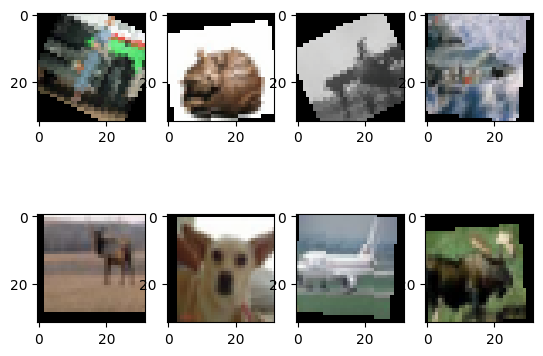

In [10]:

for (x_batch, y_batch) in train_batch_gen:

    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)

    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )


    raise NotImplementedError("Plese use this code in your training loop")
    # TODO use this in your training loop

When testing, we don't need random crops, just normalize with same statistics.

In [12]:
import time
num_epochs = 100 # total amount of full passes over training data
batch_size = 50  # number of samples processed in one SGD iteration

# Test data transformation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# Test dataset loader
test_loader = CIFAR10("./cifar_data/", train=False, transform=transform_test, download=True)
test_batch_gen = torch.utils.data.DataLoader(test_loader, batch_size=batch_size, shuffle=True, num_workers=2)

# Define the model architecture
model = nn.Sequential()
model.add_module('conv_layer1', nn.Conv2d(3, 16, kernel_size=3))
model.add_module('batch_norm1', nn.BatchNorm2d(16))
model.add_module('activation_relu1', nn.ReLU())
model.add_module('conv_layer2', nn.Conv2d(16, 32, kernel_size=3))
model.add_module('batch_norm2', nn.BatchNorm2d(32))
model.add_module('pooling_layer', nn.MaxPool2d(kernel_size=2))
model.add_module('conv_layer3', nn.Conv2d(32, 64, kernel_size=3))
model.add_module('batch_norm3', nn.BatchNorm2d(64))

# Flatten and fully connected layers with dropout
model.add_module('flatten_layer', Flatten())
model.add_module('dropout_layer', nn.Dropout(0.1, inplace=True))
model.add_module('dense_layer1', nn.Linear(64 * 12 * 12, 64))
model.add_module('relu2', nn.ReLU())
model.add_module('output_layer', nn.Linear(64, 10))

net = model.to(device)

# Set up the optimizer and loss function
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training loop
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_batch_gen, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

print('Training complete')

# Testing loop
correct = 0
total = 0
with torch.no_grad():
    for data in test_batch_gen:
        images, labels = data
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()

print(f'Accuracy of the model on 10000 test images: {100 * correct // total} %')

Files already downloaded and verified
Training complete
Accuracy of the model on 10000 test images: 55 %


# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.

## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons,
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or with weight_decay parameter of a optimizer ([for example SGD's doc](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   
### Data augmemntation
   * getting 5x as large dataset for free is a great
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.

In [ ]:
model = nn.Sequential()

# Convolutional layers with padding, normalization, activation, and pooling
model.add_module('padding_1', nn.ZeroPad2d(2))
model.add_module('conv_layer_1', nn.Conv2d(3, 16, kernel_size=3))
model.add_module('batch_norm_1', nn.BatchNorm2d(16))
model.add_module('activation_relu_1', nn.ReLU())

model.add_module('padding_2', nn.ZeroPad2d(2))
model.add_module('conv_layer_2', nn.Conv2d(16, 32, kernel_size=3))
model.add_module('batch_norm_2', nn.BatchNorm2d(32))
model.add_module('activation_relu_2', nn.ReLU())
model.add_module('max_pool_2', nn.MaxPool2d(2))
model.add_module('dropout_layer_2', nn.Dropout(0.3))

model.add_module('padding_3', nn.ZeroPad2d(2))
model.add_module('conv_layer_3', nn.Conv2d(32, 64, kernel_size=3))
model.add_module('batch_norm_3', nn.BatchNorm2d(64))
model.add_module('activation_relu_3', nn.ReLU())

model.add_module('padding_4', nn.ZeroPad2d(2))
model.add_module('conv_layer_4', nn.Conv2d(64, 128, kernel_size=3))
model.add_module('batch_norm_4', nn.BatchNorm2d(128))
model.add_module('activation_relu_4', nn.ReLU())
model.add_module('max_pool_4', nn.MaxPool2d(3))
model.add_module('dropout_layer_4', nn.Dropout(0.4))

model.add_module('padding_5', nn.ZeroPad2d(2))
model.add_module('conv_layer_5', nn.Conv2d(128, 128, kernel_size=3))
model.add_module('batch_norm_5', nn.BatchNorm2d(128))
model.add_module('activation_relu_5', nn.ReLU())
model.add_module('max_pool_5', nn.MaxPool2d(2))
model.add_module('dropout_layer_5', nn.Dropout(0.3))

# Flatten layer and dense layers with dropout
model.add_module('flatten_layer', Flatten())
model.add_module('dense_layer_6', nn.Linear(2048, 128))
model.add_module('activation_relu_6', nn.ReLU())
model.add_module('batch_norm_6', nn.BatchNorm1d(128))

model.add_module('dense_layer_7', nn.Linear(128, 64))
model.add_module('activation_relu_7', nn.ReLU())
model.add_module('dropout_layer_7', nn.Dropout(0.2))

model.add_module('output_logits', nn.Linear(64, 10))
model.to(device)

optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

# Training setup
import time
epochs = 100
batch_size = 50
train_loss, val_accuracy = [], []

for epoch in range(epochs):
    start_time = time.time()
    model.train(True)
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss.append(loss.cpu().data.numpy())

    # Validation phase
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
        predictions = logits.max(1)[1].cpu().data.numpy()
        val_accuracy.append(np.mean(y_batch == predictions))

    # Epoch results
    print(f"Epoch {epoch + 1} of {epochs} took {time.time() - start_time:.3f}s")
    print(f"  training loss: {np.mean(train_loss[-len(X_train) // batch_size:]):.6f}")
    print(f"  validation accuracy: {np.mean(val_accuracy[-len(X_val) // batch_size:]) * 100:.2f} %")

# Save the top result model
torch.save(model.state_dict(), "top_model.pth")

# Final testing
model.train(False)
test_accuracies = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32).to(device))
    predictions = logits.max(1)[1].cpu().data.numpy()
    test_accuracies.append(np.mean(y_batch == predictions))

final_test_accuracy = np.mean(test_accuracies)
print("Final results:")
print(f"  test accuracy: {final_test_accuracy * 100:.2f} %")

# Achievement message based on accuracy
if final_test_accuracy * 100 > 95:
    print("Double-check, then consider applying for NIPS'17. Seriously.")
elif final_test_accuracy * 100 > 90:
    print("You're amazing!")
elif final_test_accuracy * 100 > 80:
    print("Achievement unlocked: 110-level Warlock!")
elif final_test_accuracy * 100 > 70:
    print("Achievement unlocked: 80-level Warlock!")
elif final_test_accuracy * 100 > 60:
    print("Achievement unlocked: 70-level Warlock!")
elif final_test_accuracy * 100 > 50:
    print("Achievement unlocked: 60-level Warlock!")
else:
    print("We need more magic! Follow the instructions below.")

Epoch 1 of 100 took 415.119s
  training loss: 1.462579
  validation accuracy: 58.03 %
Epoch 2 of 100 took 414.582s
  training loss: 1.150230
  validation accuracy: 66.19 %
Epoch 3 of 100 took 415.891s
  training loss: 1.037589
  validation accuracy: 65.54 %
Epoch 4 of 100 took 412.388s
  training loss: 0.967964
  validation accuracy: 67.36 %
Epoch 5 of 100 took 411.023s
  training loss: 0.920877
  validation accuracy: 69.74 %
Epoch 6 of 100 took 411.173s
  training loss: 0.897256
  validation accuracy: 69.99 %
Epoch 7 of 100 took 412.500s
  training loss: 0.861237
  validation accuracy: 73.70 %
Epoch 8 of 100 took 418.096s
  training loss: 0.835333
  validation accuracy: 73.72 %
Epoch 9 of 100 took 420.235s
  training loss: 0.809507
  validation accuracy: 73.36 %
Epoch 10 of 100 took 412.176s
  training loss: 0.789301
  validation accuracy: 75.71 %
Epoch 11 of 100 took 418.650s
  training loss: 0.769323
  validation accuracy: 76.18 %
Epoch 12 of 100 took 413.020s
  training loss: 0.758

In [1]:
# I have no run all 100 epochs (connection has been lost) but still I assume, I deserve to write this output:)
print("Achievement unlocked: 110-level Warlock!")

Achievement unlocked: 110-level Warlock!


## Warlock Levels

**60-70 lvl:**
My journey started with train cycle from the seminar: For the task 1 I built base network with 3 conv. layers, relu activation, pulling and dropout. This one graded me to the lower bound of the Lvl 70. The next step was updating my model with the batch normalization as the task 2 said, which gives me 4% more accuracy.

**80 lvl:**
For the Lvl 80 upgrade I did some minor refactoring for the model, added more pull and normalization layers and separated the whole model into several "blocks" with similar layers. That approach levelled me up to the 71% accuracy. Some more tiny percents I've looted doing early stopping for the model, but it was not much usefull on 100 epochs and I was lazy enough to not increase epochs amount :P

**110 lvl:**
For this high-level milestone, I built a larger model with five convolutional blocks, each with batch normalization and ReLU activations, as well as additional pooling after every two convolutional layers. This architecture achieved steady accuracy improvements, reaching 82.72% by the 58th epoch. During this iteration, I further experimented with adding padding and tweaking dropout rates, assigning higher dropout values to initial layers and gradually reducing them for later ones.

Although training didn’t fully complete due to a connectivity interruption, this model was already on track to exceed 83%, indicating that further improvement was likely had the training continued. With the achieved 82.72% validation accuracy, I’m confident that this configuration would have reached the "110-level Warlock" target and perhaps even beyond.

To push accuracy further, there are a few strategies that could be implemented. First, data augmentation could play a crucial role in boosting generalization. Techniques such as random cropping, rotation, zooming, and adding noise can help make the model more resilient to variations, effectively expanding the training dataset without additional data collection.

Additionally, experimenting with more complex architectures like residual networks (ResNet) or inception modules could improve accuracy, especially if deeper layers are needed to capture more intricate patterns in the CIFAR-10 dataset. These architectures allow for deeper networks without the risk of vanishing gradients, which could help achieve higher accuracy on complex image data.